In [1]:
from bs4 import BeautifulSoup
import re
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tqdm import tqdm

In [4]:
def process_string(string):
    string = re.sub('[^A-Za-z0-9\-\/ ]+', ' ', string).split()
    return [y.strip() for y in string]

In [2]:
def parse_raw(filename):
    with open(filename, 'r') as fopen:
        entities = fopen.read()
    soup = BeautifulSoup(entities, 'html.parser')
    inside_tag = ''
    texts, labels = [], []
    for sentence in soup.prettify().split('\n'):
        if len(inside_tag):
            splitted = process_string(sentence)
            texts += splitted
            labels += [inside_tag] * len(splitted)
            inside_tag = ''
        else:
            if not sentence.find('</'):
                pass
            elif not sentence.find('<'):
                inside_tag = sentence.split('>')[0][1:]
            else:
                splitted = process_string(sentence)
                texts += splitted
                labels += ['OTHER'] * len(splitted)
    assert (len(texts)==len(labels)), "length texts and labels are not same"
    print('len texts and labels: ', len(texts))
    return texts,labels

In [5]:
train_texts, train_labels = parse_raw('data_train.txt')
test_texts, test_labels = parse_raw('data_test.txt')
train_texts += test_texts
train_labels += test_labels

len texts and labels:  34012
len texts and labels:  9249


In [6]:
with open('entities-bm-normalize-v3.txt','r') as fopen:
    entities_bm = fopen.read().split('\n')[:-1]
entities_bm = [i.split() for i in entities_bm]
entities_bm = [[i[0],'TIME' if i[0] in 'jam' else i[1]] for i in entities_bm]

In [7]:
replace_by = {'LOC':'location','PRN':'person','NORP':'organization','ORG':'organization','LAW':'law',
             'EVENT':'OTHER','FAC':'organization','TIME':'time','O':'OTHER','ART':'person','DOC':'law'}
for i in entities_bm:
    try:
        string = process_string(i[0])
        if len(string):
            train_labels.append(replace_by[i[1]])
            train_texts.append(process_string(i[0])[0])  
    except Exception as e:
        print(e)
        
assert (len(train_texts)==len(train_labels)), "length texts and labels are not same"

'KN'
'KA'


In [8]:
word2idx = {'PAD': 0,'NUM':1,'UNK':2}
tag2idx = {'PAD': 0}
char2idx = {'PAD': 0}
word_idx = 3
tag_idx = 1
char_idx = 1

def parse_XY(texts, labels):
    global word2idx, tag2idx, char2idx, word_idx, tag_idx, char_idx
    X, Y = [], []
    for no, text in enumerate(texts):
        text = text.lower()
        tag = labels[no]
        for c in text:
            if c not in char2idx:
                char2idx[c] = char_idx
                char_idx += 1
        if tag not in tag2idx:
            tag2idx[tag] = tag_idx
            tag_idx += 1
        Y.append(tag2idx[tag])
        if text not in word2idx:
            word2idx[text] = word_idx
            word_idx += 1
        X.append(text)
    return X, np.array(Y)

In [9]:
X, Y = parse_XY(train_texts, train_labels)
idx2char = {idx: tag for tag, idx in char2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}
onehot = np.zeros((Y.shape[0],len(tag2idx)))
onehot[np.arange(Y.shape[0]),Y] = 1.0

In [10]:
def str_idx(corpus, dic, UNK=0):
    maxlen = max([len(i) for i in corpus])
    X = np.zeros((len(corpus),maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i][:maxlen][::-1]):
            try:
                X[i,-1 - no]=dic[k]
            except Exception as e:
                X[i,-1 - no]=UNK
    return X

In [11]:
X_seq = str_idx(X,char2idx)

In [12]:
import json
with open('char-bidirectional.json','w') as fopen:
    fopen.write(json.dumps({'idx2tag':idx2tag, 'char2idx':char2idx,'tag2idx':tag2idx}))

In [13]:
from sklearn.cross_validation import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X_seq, onehot, test_size=0.1)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
import keras
print(keras.__version__)

2.2.2


Using TensorFlow backend.


In [15]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional
from keras.backend.tensorflow_backend import set_session
set_session(tf.InteractiveSession())

In [16]:
input_word = Input(shape=(None,))
model = Embedding(input_dim=len(char2idx) + 1, output_dim=128, mask_zero=True)(input_word)
model = Bidirectional(LSTM(units=128, return_sequences=False, recurrent_dropout=0.1))(model)
out = Dense(len(tag2idx),activation='softmax')(model)

In [17]:
model = Model(input_word, out)

In [18]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         5120      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2056      
Total params: 270,344
Trainable params: 270,344
Non-trainable params: 0
_________________________________________________________________


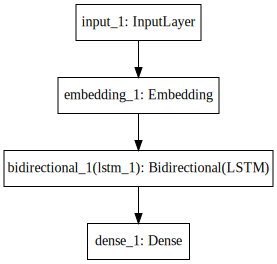

In [20]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [21]:
history = model.fit(train_X, train_Y, batch_size=32, epochs=2,
                    validation_split=0.1, verbose=1)

Train on 47341 samples, validate on 5261 samples
Epoch 1/2
47341/47341 [==============================] - 87s 2ms/step - loss: 0.6457 - acc: 0.8270 - val_loss: 0.5763 - val_acc: 0.8362
Epoch 2/2
47341/47341 [==============================] - 86s 2ms/step - loss: 0.5193 - acc: 0.8491 - val_loss: 0.4911 - val_acc: 0.8515


In [22]:
predicted = model.predict(test_X)
labels = [i[0] for i in sorted(tag2idx.items(), key=lambda t: t[1])]

In [23]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(test_Y,1), np.argmax(predicted,1), target_names=labels[1:]))

              precision    recall  f1-score   support

       OTHER       0.87      0.98      0.92      4729
organization       0.48      0.13      0.20       237
      person       0.71      0.44      0.54       386
        time       0.76      0.44      0.56       145
    location       0.64      0.18      0.28       200
    quantity       0.63      0.57      0.60       135
         law       0.00      0.00      0.00        13

 avg / total       0.83      0.85      0.83      5845



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
model.save_weights('char-bidirectional.h5')